In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import datetime
import copy

import data_helpers

In [2]:
NUMBER_BOOKIES = 5
ODDS_COLS = []
for b in range(NUMBER_BOOKIES):
    ODDS_COLS += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ODDS_COLS
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols
Required_Non_Odds_cols = Div_cols + Date_cols + Team_cols + Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols
BBAB_cols = BB_cols + AB_cols
_Cols_to_Always_Normalize = Odds_cols
_Label_cols = Full_Goal_cols + Odds_cols

In [3]:
HISTORY_LEN = 400
SEQ_YEAR_SPAN = 20
NOTE = 'FillNan'
DATA_THEME = str(HISTORY_LEN).zfill(3) + '-' + str(SEQ_YEAR_SPAN).zfill(2) + '-' + NOTE

TRAIN_MODE = True

In [4]:
COUNTRY = 'England'
NUMBER_BOOKIES = 5  # Take William Hills, Bet&Win, and Bet365. Other bookies' odds list change over years and leagues.
PREFERED_ORDER = ['B365', 'WH']   # Implies the order only.
BOOKIE_TO_EXCLUDE = []    # 'BWIN' odds don't show up since mid Febrary 2025. This may reduce the effective NUMBER_BOOKIES.
DIVIISONS = ['E0', 'E1', 'E2', 'E3']    # 'EC', the Conference league, is excluded as some odds makers are not archived for the league since 2013.

In [5]:
countryFolder = "./data/football-data-co-uk/" + COUNTRY
countryThemeFolderPath = os.path.join(countryFolder, '_THEME_' + DATA_THEME)
if not os.path.exists(countryThemeFolderPath): os.makedirs(countryThemeFolderPath, exist_ok=False)
id_map_foler_path = os.path.join(countryThemeFolderPath, '_id_map')
if not os.path.exists(id_map_foler_path): os.makedirs(id_map_foler_path, exist_ok=False)
dataset_foler_path = os.path.join(countryThemeFolderPath, '_dataaset')
if not os.path.exists(dataset_foler_path): os.makedirs(dataset_foler_path, exist_ok=False)
checkpoint_folder_path = os.path.join(countryThemeFolderPath, '_checkpoint')
if not os.path.exists(checkpoint_folder_path): os.makedirs(checkpoint_folder_path, exist_ok=False)
tokenizer_folder_path =  os.path.join(countryThemeFolderPath, '_tokenizer')
if not os.path.exists(tokenizer_folder_path): os.makedirs(tokenizer_folder_path, exist_ok=False)

In [6]:
data_helpers.assign_seasonal_filenames(countryFolder)
df_grown, df_new = data_helpers.get_grown_and_new_from_football_data_v2(countryFolder, countryThemeFolderPath, Required_Non_Odds_cols, NUMBER_BOOKIES, oddsGroupsToExclude = BOOKIE_TO_EXCLUDE, preferedOrder = PREFERED_ORDER, train_mode = TRAIN_MODE, skip=True)
if df_grown is not None: print("df_grown: ", df_grown.shape)
if df_new is not None: print("df_new: ", df_new.shape)

files found to rename:  0
total rows in renamed files:  0
df_grown:  (42095, 38)
df_new:  (0, 38)


In [10]:
def find_Electric_Flow_On_Connected_Graph(graph, source, target, inpuCurrent):
        '''
        Find the flow of electric current on each edge of 'graph' when total flow of 1.0 flows from 'source' to 'target' nodes,
        with conductance of edges stored in edge['conductance'].
        1. If 'source' and 'target' nodes are disconnected with each other, WEIRD amounts on flows on edges.
        2. If 'source' and 'target' nodes have zero conductance between them, it produces WEIRD amount of flows that violate Kirchhoff's law.
        '''
        edges = [e for e in graph.edges]        # (u, v) either u < v or u < v.
        nodes = [v for v in graph.nodes]
        edges_signs = []
        for v in nodes:
                # We want the orientation of an edge (u, v) to be from min(u, v) to max(u, v)
                edges_v = [(v, u) for u in nodes if (v, u) in graph.edges]      # all edges that have v as its node, in the form of (v,u)
                edges_v_plus = [(v, u) for (v, u) in edges_v if v > u]          # (v, u < v)
                edges_v_minus = [(v, u) for (v, u) in edges_v if v < u]         # (v, u >= v)
                edges_v_plus = [(edges.index((u, v)) if edges.count((u, v)) > 0 else edges.index((v, u))) for (u, v) in edges_v_plus]
                edges_v_minus = [(edges.index((u, v)) if edges.count((u, v)) > 0 else edges.index((v, u))) for (u, v) in edges_v_minus]
                edges_signs.append((edges_v_plus, edges_v_minus))
        matrix_B = [ [ (1 if e in edges_signs[v][1] else -1 if e in edges_signs[v][0] else 0) for e in range(len(edges)) ] for v in range(len(nodes))]
        matrix_B = np.array(matrix_B, dtype=np.float32)
        vector_C = np.array( [graph.edges[e]['conductance'] for e in edges], dtype=np.float32)
        matrix_C = np.diag(vector_C)
        matrix_L = np.dot(np.dot(matrix_B, matrix_C), matrix_B.T)
        inverse_L = np.linalg.pinv(matrix_L, hermitian=True)    # Moore-Penrose pseudo-inverse
        source_node = nodes.index(source)
        target_node = nodes.index(target)
        X_vector = np.zeros((len(nodes),), dtype=np.float32)
        X_vector[source_node] = inpuCurrent
        X_vector[target_node] = - inpuCurrent
        flows = np.matmul(matrix_C, matrix_B.T)
        flows = np.matmul(flows, inverse_L)
        flows = np.matmul(flows, X_vector)

        return flows, nodes, edges   # nodes and edges, just in case list(graph.nodes) might have different order each time.

[ 1.0000000e+00 -4.4703484e-08  6.6666663e-01  3.3333331e-01
  3.3333334e-01] [0, 1, 2, 4, 3] [(0, 1), (1, 2), (1, 4), (1, 3), (4, 3)]


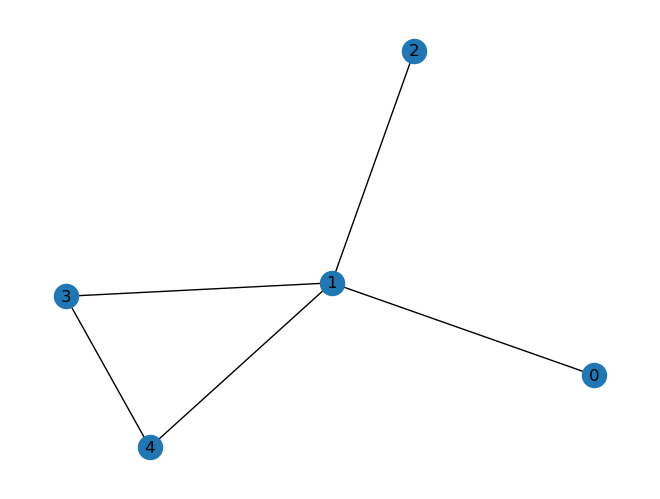

In [11]:
G = nx.path_graph(3)
G.add_edge(1,4)
G.add_edge(1,3)
G.add_edge(3,4)
# G.remove_edge(1,4)
# G.remove_edge(1,3)
for e in G.edges: G.edges[e]['conductance'] = 1
# G.edges[(1,2)]['conductance'] = 0
flow, nodes, edges = find_Electric_Flow_On_Connected_Graph(G, 0, 4, 1)
print(flow, nodes, edges)
nx.draw(G, with_labels=True)

[1.         0.12499999 0.62499994 0.24999997 0.12499999 0.375     ] [0, 1, 2, 3, 4] [(0, 1), (1, 2), (1, 4), (1, 3), (2, 3), (3, 4)]


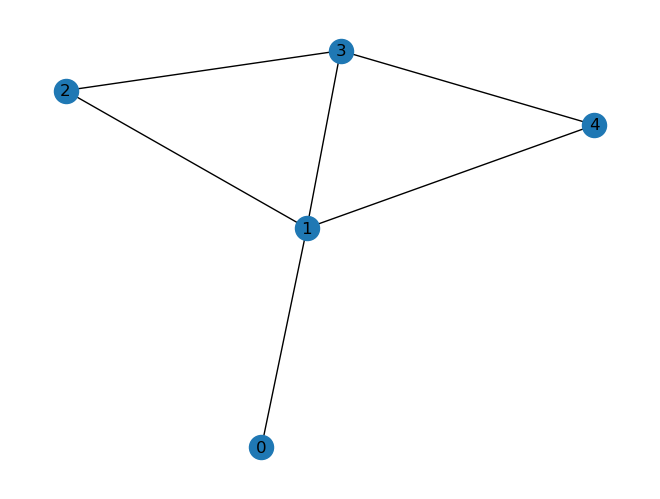

In [12]:
G = nx.path_graph(5)
G.add_edge(1,4)
G.add_edge(1,3)
G.add_edge(3,4)
# G.remove_edge(1,4)
# G.remove_edge(1,3)
for e in G.edges: G.edges[e]['conductance'] = 1
# G.edges[(1,2)]['conductance'] = 0
flow, nodes, edges = find_Electric_Flow_On_Connected_Graph(G, 0, 4, 1)
print(flow, nodes, edges)
nx.draw(G, with_labels=True)

False
[ 4.9999997e-01 -3.7252903e-09 -3.7252903e-09 -2.5000000e-01
 -2.5000000e-01  2.5000000e-01] [0, 1, 2, 3, 4, 6] [(0, 6), (1, 2), (1, 4), (1, 3), (2, 3), (3, 4)]


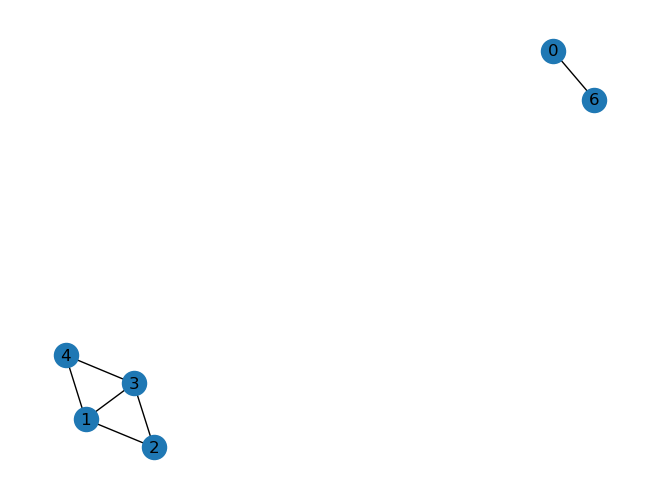

In [13]:
def reachable(graph, u, v):
        _reachable = True
        try:    nx.shortest_path_length(graph, u, v)
        except: _reachable = False
        return _reachable

G = nx.path_graph(5)
G.add_edge(1,4)
G.add_edge(1,3)
G.add_edge(3,4)
G.add_edge(0,6)
G.remove_edge(0,1)
# G.remove_edge(1,3)
print(reachable(G, 3, 6))

for e in G.edges: G.edges[e]['conductance'] = 1
# G.edges[(1,2)]['conductance'] = 0
flow, nodes, edges = find_Electric_Flow_On_Connected_Graph(G, 3, 6, 1)
print(flow, nodes, edges)
nx.draw(G, with_labels=True)

In [14]:
G = nx.path_graph(3)
print(G.edges[(0,1)], G.edges[0,1])
assert G.edges[(0,1)] == G.edges[0,1]
assert G.edges[0,1] == G.edges[1,0]

{} {}


In [15]:
id_list = list(df_grown['id']); div_list = list(df_grown['Div']); home_list = list(df_grown['HomeTeam']); away_list = list(df_grown['AwayTeam']); date_list = list(df_grown['Date'])
total_list = list(zip(id_list, div_list, date_list))
print(len(total_list))
total_list = list(zip(id_list, div_list, home_list, away_list, date_list))

42095


In [16]:
def find_nTotalGames(gameGraph):
    nTotalGames = 0
    for e in gameGraph.edges:   nTotalGames += len(gameGraph.edges[e]['games'])
    return nTotalGames

def reachable(graph, u, v):
        _reachable = True
        try:    nx.shortest_path_length(graph, u, v)
        except: _reachable = False
        return _reachable

def isConnected(gameGraph):
    connected = True
    for u in gameGraph.nodes:
        for v in gameGraph.nodes:
            if not reachable(gameGraph, u, v):
                connected = False
                break
    return connected

def createGameGraph_uk(total_list):
        graph = nx.Graph()

        for fixture_id, div, home, away, fixture_date in total_list:
                if (home, away) not in graph.edges:
                        graph.add_edge(home, away)
                        graph.edges[home, away]['games'] = []
                graph.edges[home, away]['games'].append((fixture_id, fixture_date, 0.0))        # 0.0 for conductance

        for edge in graph.edges:
                games = graph.edges[edge]['games']
                games = list(set(games))
                graph.edges[edge]['games'] = games

        return graph

113 4026 42095


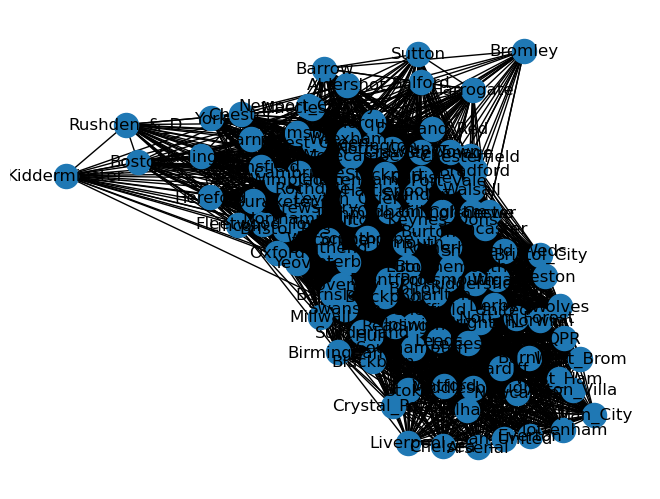

In [17]:
gg = createGameGraph_uk(total_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))

In [18]:
assert isConnected(gg)

44 732 7889


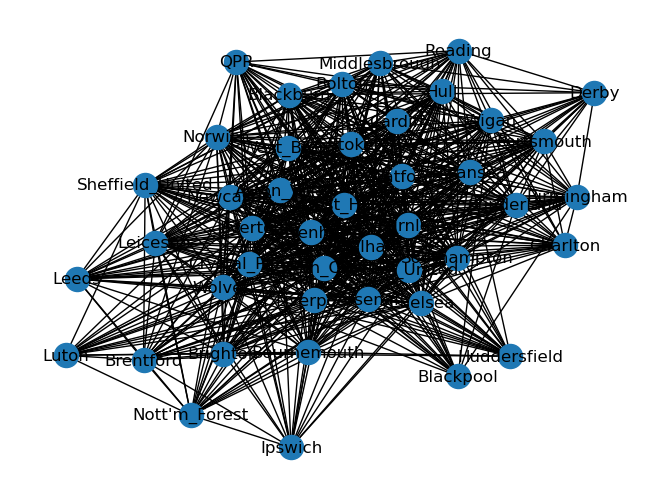

In [19]:
sub_list = [(fixture_id, div, home, away, fixture_date) for (fixture_id, div, home, away, fixture_date) in total_list if div == 'E0']
gg = createGameGraph_uk(sub_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))
assert isConnected(gg)

57 1256 11495


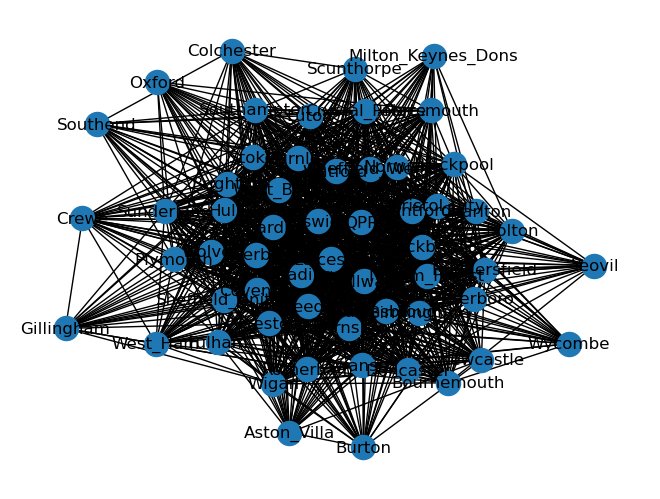

In [20]:
sub_list = [(fixture_id, div, home, away, fixture_date) for (fixture_id, div, home, away, fixture_date) in total_list if div == 'E1']
gg = createGameGraph_uk(sub_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))
assert isConnected(gg)

78 1982 11336


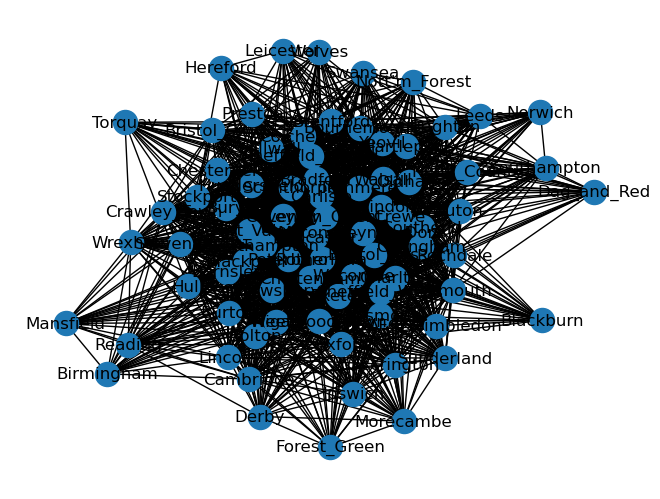

In [21]:
sub_list = [(fixture_id, div, home, away, fixture_date) for (fixture_id, div, home, away, fixture_date) in total_list if div == 'E2']
gg = createGameGraph_uk(sub_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))
assert isConnected(gg)

71 1779 11375


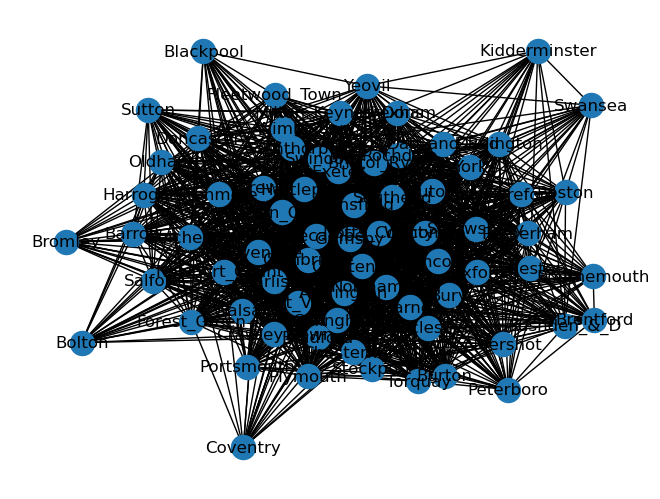

In [22]:
sub_list = [(fixture_id, div, home, away, fixture_date) for (fixture_id, div, home, away, fixture_date) in total_list if div == 'E3']
gg = createGameGraph_uk(sub_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))
assert isConnected(gg)

In [23]:
def transform_to_conducting_graph(gameGraph, baseId, baseDate, conductance365, focusPairs=None):     
        alpha = pow(conductance365, -1/365)
        def conductance(_date):
                daysAgo = (baseDate - _date).days       # > 0
                return pow(alpha, -daysAgo)             # pow(conductance365, daysAgo/365) <= 1, as conductance365 < 1
        
        pairsToRemove = []
        def update_conductance(teamA, teamB):
                edge_con = 0.0
                new_games = []
                for game in gameGraph.edges[teamA, teamB]['games']:
                        _id = game[0]; _date = game[1]  # game[2] may or may not exist.
                        if(_id < baseId):
                                sub_con = conductance(_date)
                                edge_con += sub_con  # +, as they are parallel conductances
                                # All new games have positive conductance.
                                new_games.append((_id, _date, sub_con))

                # An edge either is removed or has positive-lenth games and conductance.
                if len(new_games) <= 0:
                        pairsToRemove.append((teamA, teamB))
                else:
                        gameGraph.edges[teamA, teamB]['games'] = new_games
                        assert edge_con > 0
                        gameGraph.edges[teamA, teamB]['conductance'] = edge_con
                return

        if focusPairs is None:
                for (teamA, teamB) in gameGraph.edges:  # generats unique edges: both (1,2) and (2,1) are represented as either (1,2) or (2,1) 
                        update_conductance(teamA, teamB)
        else:
                for (teamA, teamB) in focusPairs:
                        update_conductance(teamA, teamB)

        for pair in pairsToRemove:      gameGraph.remove_edge(pair[0], pair[1])         # gameGraph.remove_edge(pair) dosen't work

        return gameGraph

In [18]:
# total_game_graph = createGameGraph_uk(total_list)

# HISTORY_LEN = 400

# unreachables = 0
# for (base_id, div, home, away, base_date) in total_list:      # date: yyyy-mm-dd
#     sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in total_list if id < base_id]
#     if len(sub_list) <= HISTORY_LEN:
#         games = [id for (id, _, _, _, _) in sub_list]
#     else:
#         gg = copy.deepcopy(total_game_graph)
#         gg = transform_to_conducting_graph(gg, base_id, base_date, conductance365=0.9, focusPairs=None)
#         if reachable(gg, home, away):   
#             pass
#         else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph.
#             # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
#             unreachables += 1
#             print(unreachables, ' Not reachable ', base_id)
#             games = [id for (id, _, _, _, _) in sub_list[- HISTORY_LEN: ]]  # collect the latest HISTORY_LEN games.

In [24]:
def create_conducting_game_graph_uk(game_list, baseDate, conductance365):
        # game_list is sorted in (date, div).
        graph = nx.Graph()
        alpha = pow(conductance365, -1/365)
        def conductance(_date):
                daysAgo = (baseDate - _date).days       # > 0
                return pow(alpha, -daysAgo)             # pow(conductance365, daysAgo/365) <= 1, as conductance365 < 1

        for id, div, home, away, dt in game_list:
                if (home, away) not in graph.edges:
                        graph.add_edge(home, away)
                        graph.edges[home, away]['games'] = []
                graph.edges[home, away]['games'].append((id, dt, conductance(dt)))

        for edge in graph.edges:
                games = graph.edges[edge]['games']
                edge_con = 0.0
                for (_, _, con) in games: edge_con += con
                graph.edges[edge]['conductance'] = edge_con

        return graph

In [20]:
# HISTORY_LEN = 400

# # execution time: 21m 18s, unreachables: 24
# for (base_id, div, home, away, base_date) in total_list:      # date: yyyy-mm-dd
#     sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in total_list if id < base_id]

#     if len(sub_list) <= HISTORY_LEN:
#         games = [id for (id, _, _, _, _) in sub_list]
#     else:
#         gg = create_conducting_game_graph_uk(sub_list, base_date, conductance365=0.9)   # MUCH faster than transform_to_conducting_graph

#         if reachable(gg, home, away):   
#             pass
#         else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph. They might be inter-league games.
#             # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
#             print('Not reachable ', base_id)
#             games = [id for (id, _, _, _, _) in sub_list[- HISTORY_LEN: ]]  # collect the latest HISTORY_LEN games.

In [25]:
def find_games(gameGraph):
    games = []
    for e in gameGraph.edges:   games += [id for (id, date, con) in gameGraph.edges[e]['games']]
    return games

def try_remove_lowest_flow_games(gameGraph, eFlows, edges, targetLength):
    # print('5 entering removal. nTotal: ', find_nTotalGames(gameGraph))
    emptyPairs = []
    currents = []
    for (teamA, teamB) in gameGraph.edges:  # May not: teamA < teamB
            # get the current on the edge (teamA, teamB)
            eId = (edges.index((teamA, teamB)) if edges.count((teamA, teamB)) > 0 else edges.index((teamB, teamA))) # Exists
            flow = abs(eFlows[eId])
            
            if len(gameGraph.edges[teamA, teamB]['games']) <= 0:
                    emptyPairs.append((teamA, teamB))
            else:
                    edge_conductance = gameGraph.edges[teamA, teamB]['conductance'] # Asserted positive, no need epsilon.
                    currentPerUnitCon = flow / edge_conductance
                    pair_games = gameGraph.edges[teamA, teamB]['games']     # Creates a set of pair expressions.
                    pair_current = [(currentPerUnitCon * cond, id, date, cond, teamA, teamB) for (id, date, cond) in pair_games]
                    currents += pair_current

    # Note: Pair representations (A, B) in currents came from [for (A, B) in gameGraph.edges]
    for (teamA, teamB) in emptyPairs:   gameGraph.remove_edge(teamA, teamB)
    assert find_nTotalGames(gameGraph) == len(currents)

    currents = [(date, curr, id, cond, teamA, teamB) for (curr, id, date, cond, teamA, teamB) in currents]
    currents.sort(reverse=True)     # later dates come first
    currents = [(curr, id, date, cond, teamA, teamB) for (date, curr, id, cond, teamA, teamB) in currents]
    currents.sort(reverse=True)    # larger current comes first

    if len(currents) <= targetLength:   pass
    else:
        currents = currents[ : targetLength ]

        pairsChanged = []
    
        nGoal = len(currents)

        #-----------------------------------------------------------------------------------------------------
        #   Below, 'currents' is reflected to gameGraph. No more pairs/games are removed, except that.
        #-----------------------------------------------------------------------------------------------------

        #======== Find <which games on which pair> are in 'currents'
        pairsInCurrents = list(set([(teamA, teamB) for (_,_,_,_, teamA, teamB) in currents]))
        gamesByPairInCurrents = [ ( (teamA, teamB), [(id, date, con) for (_, id, date, con, _teamA, _teamB) in currents 
            if _teamA == teamA and _teamB == teamB ] )      # currents and pairs_from_current share the same expressions of pair.
            for (teamA, teamB) in pairsInCurrents]       # May not: teamA < teamB

        #========= Remove existing pairs that are not in pairsInCurrents, that has no game at all in currents.
        allPairs = [(teamA, teamB) for (teamA, teamB) in gameGraph.edges]   # Pair representatoin comes from [for (A, B) in gameGraph.edges]
        pairsToRemove = [(teamA, teamB) for (teamA, teamB) in allPairs if (teamA, teamB) not in pairsInCurrents]
        for (teamA, teamB) in pairsToRemove:  gameGraph.remove_edge(teamA, teamB)

        #========= Replace existing games of pairsInCurrents with games found in 'currents' if appropriate.  
        for ((teamA, teamB), games) in gamesByPairInCurrents:
            if len(gameGraph.edges[teamA, teamB]['games']) != len(games):   # if some games were excluded.
                gameGraph.edges[teamA, teamB]['games'] = games  # Replace.
                pairsChanged.append((teamA, teamB))

        #========= Update nTotalGames
        nTotalGames = find_nTotalGames(gameGraph)
        assert nTotalGames == targetLength

    # print('10, returning from removal. nTotalGames: ', nTotalGames)

    return gameGraph, nTotalGames, pairsChanged, currents

In [26]:
def get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365):
        games = []; report = 0
        if len(div_sub_list) <= history_len:
                games = [id for (id, _, _, _, _) in div_sub_list]
        else:
                gg = create_conducting_game_graph_uk(div_sub_list, base_date, conductance365=conductance365)   # MUCH faster than transform_to_conducting_graph

                if reachable(gg, home, away):
                        flows, nodes, edges = find_Electric_Flow_On_Connected_Graph(gg, home, away, inputCurrent)
                        flows_copy = copy.deepcopy(flows)
                        flows_copy = [abs(f) for f in flows_copy]
                        flows_copy.sort(reverse=True)

                        if  flows_copy[0] > inputCurrent/10000:
                                # either isConnected(gg) or not.
                                gg, nTotalGames, pairsChanged, currents = try_remove_lowest_flow_games(gg, flows, edges, history_len)
                                games = find_games(gg)
                                assert len(games) == history_len
                                report = 0
                        else:
                                games = [id for (id, div, home, away, dt) in div_sub_list[- history_len : ]]  # collect latest ids
                                report = 1

                else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph. They might be inter-league games.
                        # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
                        games = [id for (id, _,_,_,_) in div_sub_list[- history_len : ]]   # collect latest ids
                        report = 2

        return games, report

        

def get_historical_games(base_id, base_date, base_div, home, away, sub_list, history_len, inputCurrent, conductance365):
        games = []; report = 0
        if len(sub_list) <= history_len:
                games = [id for (id, _, _, _, _) in sub_list]
        else:
                gg = create_conducting_game_graph_uk(sub_list, base_date, conductance365=conductance365)   # MUCH faster than transform_to_conducting_graph

                if reachable(gg, home, away):
                        flows, nodes, edges = find_Electric_Flow_On_Connected_Graph(gg, home, away, inputCurrent)
                        flows_copy = copy.deepcopy(flows)
                        flows_copy = [abs(f) for f in flows_copy]
                        flows_copy.sort(reverse=True)

                        if  flows_copy[0] > inputCurrent/10000: # No other way to find the e flow problem was successful.
                                # either isConnected(gg) or not.
                                gg, nTotalGames, pairsChanged, currents = try_remove_lowest_flow_games(gg, flows, edges, history_len)
                                games = find_games(gg)
                                assert len(games) == history_len
                                report = 0
                        else:
                                # either isConnected(gg) or not.
                                div_sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in sub_list if div == base_div]
                                games, _report = get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365)
                                report = 10 + _report

                else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph. They might be inter-league games.
                        # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
                        div_sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in sub_list if div == base_div]
                        games, _report = get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365)
                        report = 20 + _report

                if not isConnected(gg): report += 100

        games.sort(reverse=True)
        return games, report


In [23]:
# HISTORY_LEN = 400
# inputCurrent = 1000.0

# # execution time: 21m 18s, unreachables: 24

# id_list = list(df['id']); div_list = list(df['Div']); home_list = list(df['HomeTeam']); away_list = list(df['AwayTeam']); date_list = list(df['Date'])
# total_list = list(zip(id_list, div_list, home_list, away_list, date_list))

# max_days_span = 0
# reachable_inter = reachable_intra = nonreachable_intra = 0
# for (base_id, div, home, away, base_date) in total_list:      # date: yyyy-mm-dd
#     sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in total_list if id < base_id]

#     games, _reachable_inter, _reachable_intra, _nonreachable_intra = get_historical_games(base_id, base_date, div, home, away, sub_list, HISTORY_LEN, inputCurrent, conductance365=0.9)
#     reachable_inter += _reachable_inter
#     reachable_intra += _reachable_intra
#     nonreachable_intra += _nonreachable_intra

#     if len(games) > 0: days_span = (base_date - date_list[id_list.index(games[-1])]).days
#     else: days_span = 0
#     if max_days_span < days_span: max_days_span = days_span

#     print("base_id: ' {}, 'reachable_inter: ' {}, 'reachable_intra: ' {}, 'nonreachable_intra: ' {}, 'days_span: ' {}, 'games[:10]: ' {}" \
#             .format(base_id, reachable_inter, reachable_intra, nonreachable_intra, days_span, games[:10]), end='\r')

# print('max_days_span = ', max_days_span)


In [25]:
def fixture_id_to_ids_uk_latest(folder, id_to_ids_filename, targetLength, df_total, year_span, testcount=-1):

        def find_Electric_Flow_On_Connected_Graph(graph, source, target, inpuCurrent):
                '''
                Find the flow of electric current on each edge of 'graph' when total flow of 1.0 flows from 'source' to 'target' nodes,
                with conductance of edges stored in edge['conductance'].
                1. If 'source' and 'target' nodes are disconnected with each other, WEIRD amounts on flows on edges.
                2. If 'source' and 'target' nodes have zero conductance between them, it produces WEIRD amount of flows that violate Kirchhoff's law.
                '''
                edges = [e for e in graph.edges]        # (u, v) either u < v or u < v.
                nodes = [v for v in graph.nodes]
                edges_signs = []
                for v in nodes:
                        # We want the orientation of an edge (u, v) to be from min(u, v) to max(u, v)
                        edges_v = [(v, u) for u in nodes if (v, u) in graph.edges]      # all edges that have v as its node, in the form of (v,u)
                        edges_v_plus = [(v, u) for (v, u) in edges_v if v > u]          # (v, u < v)
                        edges_v_minus = [(v, u) for (v, u) in edges_v if v < u]         # (v, u >= v)
                        edges_v_plus = [(edges.index((u, v)) if edges.count((u, v)) > 0 else edges.index((v, u))) for (u, v) in edges_v_plus]
                        edges_v_minus = [(edges.index((u, v)) if edges.count((u, v)) > 0 else edges.index((v, u))) for (u, v) in edges_v_minus]
                        edges_signs.append((edges_v_plus, edges_v_minus))
                matrix_B = [ [ (1 if e in edges_signs[v][1] else -1 if e in edges_signs[v][0] else 0) for e in range(len(edges)) ] for v in range(len(nodes))]
                matrix_B = np.array(matrix_B, dtype=np.float32)
                vector_C = np.array( [graph.edges[e]['conductance'] for e in edges], dtype=np.float32)
                matrix_C = np.diag(vector_C)
                matrix_L = np.dot(np.dot(matrix_B, matrix_C), matrix_B.T)
                inverse_L = np.linalg.pinv(matrix_L, hermitian=True)    # Moore-Penrose pseudo-inverse
                source_node = nodes.index(source)
                target_node = nodes.index(target)
                X_vector = np.zeros((len(nodes),), dtype=np.float32)
                X_vector[source_node] = inpuCurrent
                X_vector[target_node] = - inpuCurrent
                flows = np.matmul(matrix_C, matrix_B.T)
                flows = np.matmul(flows, inverse_L)
                flows = np.matmul(flows, X_vector)

                return flows, nodes, edges   # nodes and edges, just in case list(graph.nodes) might have different order each time.

        def find_nTotalGames(gameGraph):
                nTotalGames = 0
                for e in gameGraph.edges:   nTotalGames += len(gameGraph.edges[e]['games'])
                return nTotalGames

        def reachable(graph, u, v):
                _reachable = True
                try:    nx.shortest_path_length(graph, u, v)
                except: _reachable = False
                return _reachable

        def isConnected(gameGraph):
                connected = True
                for u in gameGraph.nodes:
                        for v in gameGraph.nodes:
                                if not reachable(gameGraph, u, v):
                                        connected = False
                                        break
                return connected

        def create_conducting_game_graph_uk(game_list, baseDate, conductance365):
                # game_list is sorted in (date, div).
                graph = nx.Graph()
                alpha = pow(conductance365, -1/365)
                def conductance(_date):
                        daysAgo = (baseDate - _date).days       # > 0
                        return pow(alpha, -daysAgo)             # pow(conductance365, daysAgo/365) <= 1, as conductance365 < 1

                for id, div, home, away, dt in game_list:
                        if (home, away) not in graph.edges:
                                graph.add_edge(home, away)
                                graph.edges[home, away]['games'] = []
                        graph.edges[home, away]['games'].append((id, dt, conductance(dt)))

                for edge in graph.edges:
                        games = graph.edges[edge]['games']
                        edge_con = 0.0
                        for (_, _, con) in games: edge_con += con
                        graph.edges[edge]['conductance'] = edge_con

                return graph


        def find_games(gameGraph):
                games = []
                for e in gameGraph.edges:   games += [id for (id, date, con) in gameGraph.edges[e]['games']]
                return games

        def try_remove_lowest_flow_games(gameGraph, eFlows, edges, targetLength):
                # print('5 entering removal. nTotal: ', find_nTotalGames(gameGraph))
                emptyPairs = []
                currents = []
                for (teamA, teamB) in gameGraph.edges:  # May not: teamA < teamB
                        # get the current on the edge (teamA, teamB)
                        eId = (edges.index((teamA, teamB)) if edges.count((teamA, teamB)) > 0 else edges.index((teamB, teamA))) # Exists
                        flow = abs(eFlows[eId])
                        
                        if len(gameGraph.edges[teamA, teamB]['games']) <= 0:
                                emptyPairs.append((teamA, teamB))
                        else:
                                edge_conductance = gameGraph.edges[teamA, teamB]['conductance'] # Asserted positive, no need epsilon.
                                currentPerUnitCon = flow / edge_conductance
                                pair_games = gameGraph.edges[teamA, teamB]['games']     # Creates a set of pair expressions.
                                pair_current = [(currentPerUnitCon * cond, id, date, cond, teamA, teamB) for (id, date, cond) in pair_games]
                                currents += pair_current

                # Note: Pair representations (A, B) in currents came from [for (A, B) in gameGraph.edges]
                for (teamA, teamB) in emptyPairs:   gameGraph.remove_edge(teamA, teamB)
                assert find_nTotalGames(gameGraph) == len(currents)

                currents = [(date, curr, id, cond, teamA, teamB) for (curr, id, date, cond, teamA, teamB) in currents]
                currents.sort(reverse=True)     # later dates come first
                currents = [(curr, id, date, cond, teamA, teamB) for (date, curr, id, cond, teamA, teamB) in currents]
                currents.sort(reverse=True)    # larger current comes first

                if len(currents) <= targetLength:   pass
                else:
                        currents = currents[ : targetLength ]
                        pairsChanged = []
                        #-----------------------------------------------------------------------------------------------------
                        #   Below, 'currents' is reflected to gameGraph. No more pairs/games are removed, except that.
                        #-----------------------------------------------------------------------------------------------------

                        #======== Find <which games on which pair> are in 'currents'
                        pairsInCurrents = list(set([(teamA, teamB) for (_,_,_,_, teamA, teamB) in currents]))
                        gamesByPairInCurrents = [ ( (teamA, teamB), [(id, date, con) for (_, id, date, con, _teamA, _teamB) in currents 
                                if _teamA == teamA and _teamB == teamB ] )      # currents and pairs_from_current share the same expressions of pair.
                                for (teamA, teamB) in pairsInCurrents]       # May not: teamA < teamB

                        #========= Remove existing pairs that are not in pairsInCurrents, that has no game at all in currents.
                        allPairs = [(teamA, teamB) for (teamA, teamB) in gameGraph.edges]   # Pair representatoin comes from [for (A, B) in gameGraph.edges]
                        pairsToRemove = [(teamA, teamB) for (teamA, teamB) in allPairs if (teamA, teamB) not in pairsInCurrents]
                        for (teamA, teamB) in pairsToRemove:  gameGraph.remove_edge(teamA, teamB)

                        #========= Replace existing games of pairsInCurrents with games found in 'currents' if appropriate.  
                        for ((teamA, teamB), games) in gamesByPairInCurrents:
                                if len(gameGraph.edges[teamA, teamB]['games']) != len(games):   # if some games were excluded.
                                        gameGraph.edges[teamA, teamB]['games'] = games  # Replace.
                                        pairsChanged.append((teamA, teamB))

                        #========= Update nTotalGames
                        nTotalGames = find_nTotalGames(gameGraph)
                        assert nTotalGames == targetLength

                # print('10, returning from removal. nTotalGames: ', nTotalGames)

                return gameGraph, nTotalGames, pairsChanged, currents


        def get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365):
                games = []; report = 0
                if len(div_sub_list) <= history_len:
                        games = [id for (id, _, _, _, _) in div_sub_list]
                        report = 10
                else:
                        dgg = create_conducting_game_graph_uk(div_sub_list, base_date, conductance365=conductance365)   # MUCH faster than transform_to_conducting_graph

                        if reachable(dgg, home, away):
                                flows, nodes, edges = find_Electric_Flow_On_Connected_Graph(dgg, home, away, inputCurrent)
                                flows_copy = copy.deepcopy(flows)
                                flows_copy = [abs(f) for f in flows_copy]
                                flows_copy.sort(reverse=True)

                                if  flows_copy[0] > inputCurrent/100:
                                        # either isConnected(dgg) or not.
                                        dgg, nTotalGames, pairsChanged, currents = try_remove_lowest_flow_games(dgg, flows, edges, history_len)
                                        games = find_games(dgg)
                                        assert len(games) == history_len
                                        report = 20
                                else:
                                        games = [id for (id, div, home, away, dt) in div_sub_list[- history_len : ]]  # collect latest ids
                                        report = 30

                        else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph. They might be inter-league games.
                                # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
                                games = [id for (id, _,_,_,_) in div_sub_list[- history_len : ]]   # collect latest ids
                                report = 40

                return games, report
        
             
     
        def get_historical_games(base_id, base_date, base_div, home, away, sub_list, history_len, inputCurrent, conductance365):
                games = []; report = None
                if len(sub_list) <= history_len:
                        games = [id for (id, _, _, _, _) in sub_list]      # better than dummy games.
                        report = 100
                else:
                        gg = create_conducting_game_graph_uk(sub_list, base_date, conductance365=conductance365)   # MUCH faster than transform_to_conducting_graph

                        if reachable(gg, home, away):
                                flows, nodes, edges = find_Electric_Flow_On_Connected_Graph(gg, home, away, inputCurrent)
                                flows_abs = copy.deepcopy(flows)
                                flows_abs = [abs(f) for f in flows_abs]
                                flows_abs.sort(reverse=True)

                                if  flows_abs[0] > inputCurrent/100: # No other way to find the e flow problem was successful.
                                        # either isConnected(gg) or not.
                                        gg, nTotalGames, pairsChanged, currents = try_remove_lowest_flow_games(gg, flows, edges, history_len)
                                        games = find_games(gg)
                                        assert len(games) == history_len
                                        report = 200
                                else:
                                        # either isConnected(gg) or not.
                                        div_sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in sub_list if div == base_div]
                                        games, _report = get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365)
                                        report = 300 + _report
                                        
                        else: # Very rare. Few games are new edge in the conductance graph after collecting at lease HISTORY_LEN past games in the graph. They might be inter-league games.
                                # find_Electric_Flow_On_Connected_Graph(.) doesn't work here.
                                div_sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in sub_list if div == base_div]
                                games, _report = get_historical_games_intra_div(base_id, base_date, base_div, home, away, div_sub_list, history_len, inputCurrent, conductance365)
                                report = 400 + _report

                        if len(games) < history_len:
                                candi_games = [id for (id, _, _, _, _) in sub_list if id not in games]
                                games = games + candi_games[ : history_len - len(games)]
                                report += 1     # 200, 311, 320, 420, 330

                        assert len(games) == history_len

                        # if not isConnected(gg): report += 1000         # expensive

                games.sort(reverse=True)
                return games, report
        
        def sort_id_to_ids(id_to_ids):
                dates_ids = [(baseId, report, games) for (baseId, (report, games)) in id_to_ids.items()]
                dates_ids.sort()        # increasing on baseId
                # print('dates_ids', dates_ids)
                id_to_ids = {int(baseId): (report, games) for (baseId, report, games) in dates_ids}
                return id_to_ids
        
        def save_step_id_to_ids(path, step_id_to_ids, work_id_to_ids, old_step):
                save = {}
                if old_step >= 0:
                        if len(work_id_to_ids) > 0:   # Don't save anew unless we have extra id_to_ids, because this saving sometimes saves a wrong file.'"Electrical Flows 2.pdf"
                                save = step_id_to_ids | sort_id_to_ids(work_id_to_ids)
                                data_helpers.SaveJsonData(save, path)
                        else:
                                save = step_id_to_ids
                return save

        #=========================================================================== Main =======================================================================

        id_list = list(df_total['id']); div_list = list(df_total['Div']); home_list = list(df_total['HomeTeam']); away_list = list(df_total['AwayTeam']); date_list = list(df_total['Date'])
        total_list = list(zip(id_list, div_list, home_list, away_list, date_list))

        step_size = int(1E3)        # do not change.
        old_step = -1
        total_id_to_ids = {}
        step_id_to_ids = {}
        work_id_to_ids = {}

        # df_built = df_built.sort_values(['Date', 'Div'], ascending=[True, True])
        
        max_days_covered = 0; count = 0
        for (base_id, div, home, away, base_date) in total_list:      # date: yyyy-mm-dd
                if count == testcount: break
                count += 1

                step = int(base_id/step_size) * step_size   # sure step >= 0

                def build_path(step):
                        return os.path.join(folder, id_to_ids_filename + '-step-' + str(step) + '-size-' + str(step_size) + '.json')

                # Note the final step is always not saved. Save it after this loop.
                if step != old_step:    # We are turning to a new step.
                        save = save_step_id_to_ids(build_path(old_step), step_id_to_ids, work_id_to_ids, old_step)
                        total_id_to_ids = total_id_to_ids | save
                        step_id_to_ids = {}
                        path = build_path(step)
                        id_to_ids_read = data_helpers.LoadJsonData(path)
                        if id_to_ids_read is not None:
                                step_id_to_ids = id_to_ids_read
                        work_id_to_ids = {}
                        old_step = step
                
                if str(base_id) in step_id_to_ids.keys():  continue

                #------------------------------------------------------------------------------------------------------- Goal: get games.
                #????????????????????????????????????? Shall we limit the list to max 5 years ?????????????????????????????????????????????????
                day_span = year_span * 365
                sub_list = [(id, div, home, away, dt) for (id, div, home, away, dt) in total_list if id < base_id and (base_date-dt).days < day_span]
                inputCurrent = 1000.0
                games, report = get_historical_games(base_id, base_date, div, home, away, sub_list, targetLength, inputCurrent, conductance365=0.9)

                if len(games) > 0: days_covered = (base_date - date_list[id_list.index(games[-1])]).days
                else: days_covered = 0
                if max_days_covered < days_covered: max_days_covered = days_covered

                print("base_id: {}, report: {}, days_span: {}, games[:10]: {}" \
                      .format(base_id, report, days_covered, games[:10]), end='\r')
                #-------------------------------------------------------------------------------------------------------

                if len(games) >= 0: work_id_to_ids[base_id] = (report, games)

        # Give a chance to the final step to save.
        save = save_step_id_to_ids(build_path(old_step), step_id_to_ids, work_id_to_ids, old_step)
        total_id_to_ids = total_id_to_ids | save

        return total_id_to_ids

In [28]:
#================= build_id_to_ids.ipynb

targetLength = HISTORY_LEN          # A target game will be explained by maximum 'targetLength' count of past games.

id_map_filename = DATA_THEME
id_map_filePath = os.path.join(id_map_foler_path, id_map_filename + ".json")

df_total = df_grown; df_search = df_grown
id_map = data_helpers.fixture_id_to_ids_uk_v3(id_map_foler_path, id_map_filename, targetLength, df_total, year_span=SEQ_YEAR_SPAN, testcount=-1)
data_helpers.SaveJsonData(id_map, id_map_filePath)

print(len(id_map))

42095


42095
0: 1011373 200 400 (1011373, 'E0', 'Man_City', 'Portsmouth', datetime.date(2010, 1, 31))
0.1:  ['E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0', 'E0'

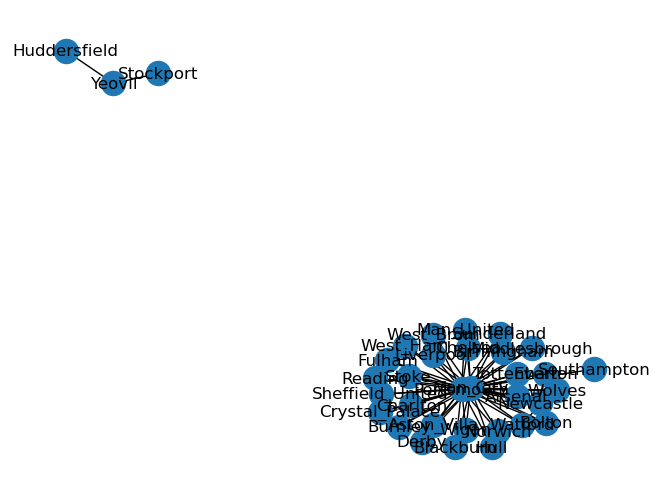

In [38]:
print(len(total_list))
id_list = list(df_grown['id']); div_list = list(df_grown['Div']); home_list = list(df_grown['HomeTeam']); away_list = list(df_grown['AwayTeam']); date_list = list(df_grown['Date'])
total_list = list(zip(id_list, div_list, home_list, away_list, date_list))

focus = 11372         # 10000, 30006    30250 (Man_united, Arsenal), 10000 (Cheltenham, Notts_County), 10001 (Chesterfield, Accrington)
sub_list = [(id, div, home, away, date) for (id, div, home, away, date) in total_list if id in id_map[str(id_list[focus])][1]]
print('0:', id_list[focus], id_map[str(id_list[focus])][0], len(sub_list), total_list[focus])
divs = [div for (id, div, home, away, date) in sub_list]
print('0.1: ', divs)
gg = createGameGraph_uk(sub_list)
nx.draw(gg, with_labels=True)
edges = list(gg.edges)
nodes = [a for (a,b) in edges] + [b for (a, b) in edges]
unique_nodes = list(set(nodes))
print('1:', len(gg.nodes), len(gg.edges), find_nTotalGames(gg), len(nodes), len(unique_nodes))
nodes_count = [(nodes.count(n), n) for n in unique_nodes]
nodes_count.sort(reverse=True)
print('2:', len(nodes_count), nodes_count)
print('3:', sub_list[0])